In [1]:
business_json_path =  "yelp_academic_dataset_business.json"
checkin_json_path =  "yelp_academic_dataset_checkin.json"
tip_json_path =  "yelp_academic_dataset_tip.json"
reviews_json_path =  "yelp_academic_dataset_review.json"
attributes_csv_path = 'yelp_business_attributes.csv'

In [2]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
import etl
import eda
from preprocess import TextProcessor

In [ ]:
#Extract data
etl_worker = ETL(etl.DATA_DIR + business_json_path, etl.DATA_DIR + checkin_json_path, etl.DATA_DIR + reviews_json_path, ['VA', 'NC'])

In [ ]:
# Format data
tp = TextProcessor(etl_worker.df)
tp.update_feats()
df = tp.df

In [159]:
df = pd.read_csv(etl.DATA_DIR + '/data/saved_df.csv')

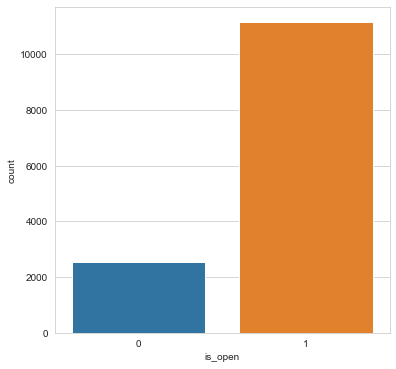

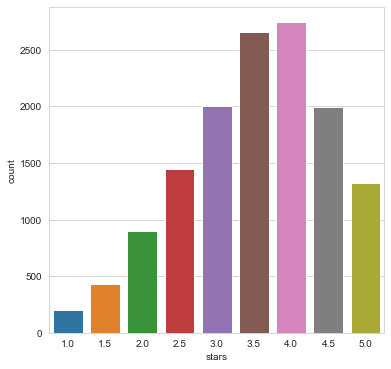

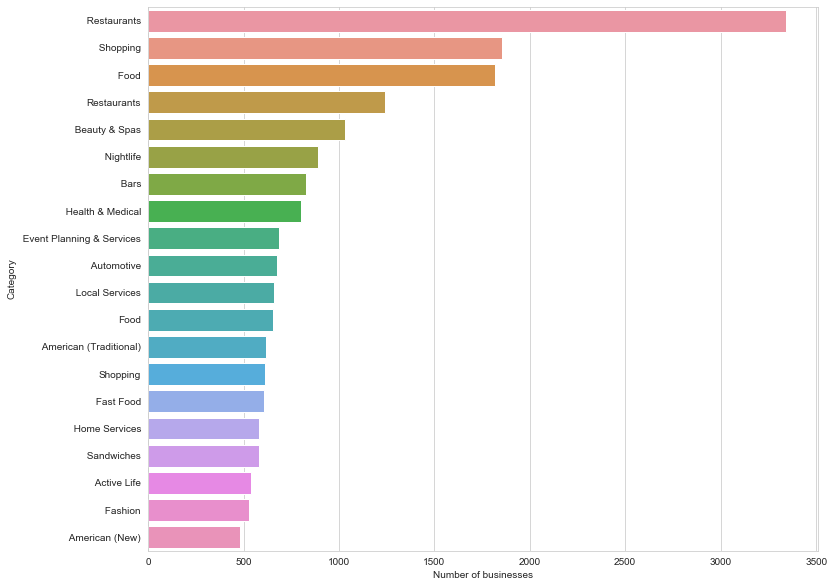

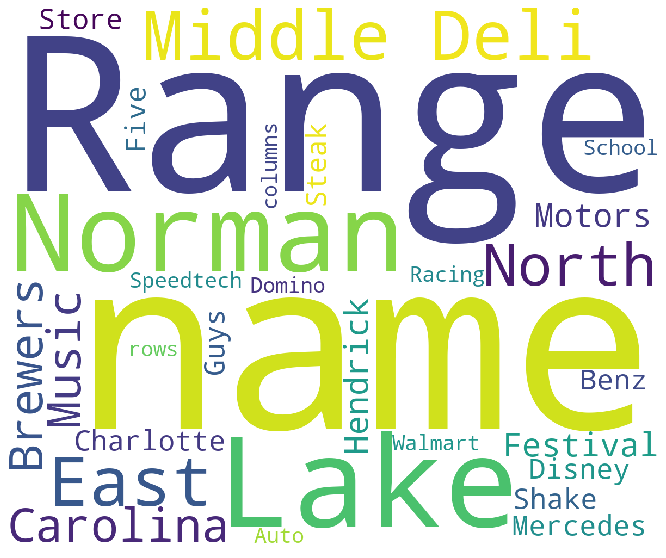

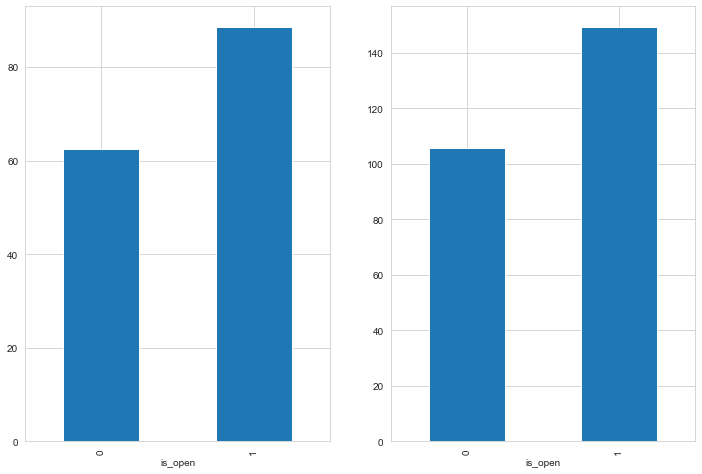

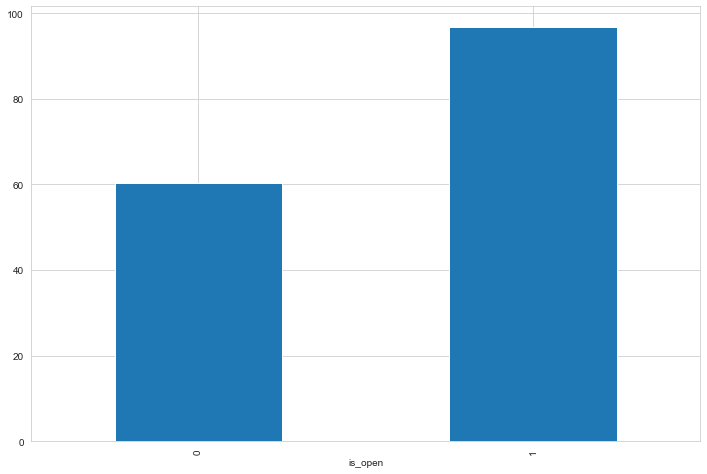

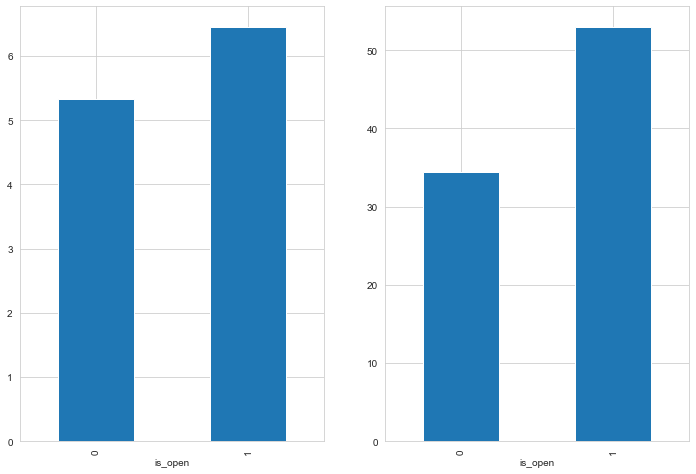

In [8]:
# EDA
%matplotlib inline
eda.show_all(df)

In [12]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'checkins', 'interval',
       'MedianStars', 'MeanStars', 'text', 'e', 'q', 'punc', 'chars', 'words',
       'sent_1_score', 'sent_1_rate', 'sent_1_pct', 'sent_1_nct',
       'sent_2_score', 'sent_2_rate', 'sent_2_pct', 'sent_2_nct'],
      dtype='object')

In [58]:
cols = ['stars', 'review_count', 'checkins', 'interval', 'MedianStars', 'MeanStars', 'e', 'q', 'chars', 'sent_1_score', 'sent_1_rate', 'sent_1_nct', 'sent_1_pct', 'sent_2_score', 'sent_2_rate', 'sent_2_pct', 'sent_2_nct']

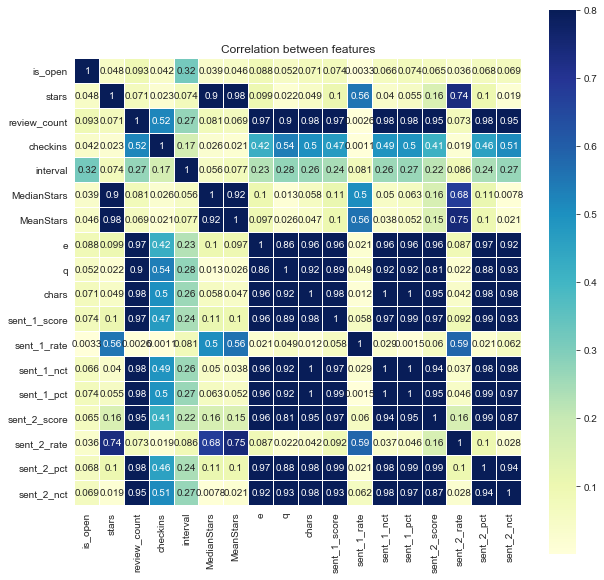

In [60]:
corr_matrix = X_res[ ['is_open', 'stars', 'review_count', 'checkins', 'interval', 'MedianStars', 'MeanStars', 'e', 'q', 'chars', 'sent_1_score', 'sent_1_rate', 'sent_1_nct', 'sent_1_pct', 'sent_2_score', 'sent_2_rate', 'sent_2_pct', 'sent_2_nct']].corr()
corr_matrix
import seaborn
plt.figure(figsize=(10, 10))
seaborn.heatmap(abs(corr_matrix), vmax=.8, linewidths=0.01, square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [61]:
X_res.isnull().sum()

stars           0
review_count    0
checkins        0
interval        0
MedianStars     0
MeanStars       0
e               0
q               0
chars           0
sent_1_score    0
sent_1_rate     0
sent_1_nct      0
sent_1_pct      0
sent_2_score    0
sent_2_rate     0
sent_2_pct      0
sent_2_nct      0
is_open         0
dtype: int64

In [98]:
X_res.describe()

,stars,review_count,checkins,interval,MedianStars,MeanStars,e,q,chars,sent_1_score,sent_1_rate,sent_1_nct,sent_1_pct,sent_2_score,sent_2_rate,sent_2_pct,sent_2_nct
count,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000,15610.000000
mean,3.479748,31.000128,74.677002,1398.269122,3.660444,3.481014,43.946124,5.765919,15250.322293,76.127512,0.022129,284.993183,548.339303,128.817768,0.034741,199.654888,70.837121
std,0.870397,67.414911,184.066559,1094.014358,1.224011,0.858020,103.399235,13.018836,33213.655319,170.575395,0.008790,626.620643,1171.524037,326.555324,0.022184,470.035997,157.100009
min,1.000000,3.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,312.000000,-7.125000,-0.035473,1.000000,6.000000,-489.000000,-0.081081,0.000000,0.000000
25%,3.000000,5.000000,5.000000,426.000000,3.000000,2.962267,5.000000,0.000000,2315.500000,11.250000,0.017126,41.011970,84.443945,14.034278,0.021240,27.616811,9.993151
50%,3.500000,10.000000,17.000000,1201.500000,4.000000,3.545455,13.000000,2.000000,5053.000000,24.937713,0.021975,92.000000,187.000000,34.460737,0.035056,59.233196,24.000000
75%,4.000000,29.000000,64.000000,2298.000000,4.917195,4.087866,40.000000,6.000000,13787.750000,68.265795,0.026974,258.000000,505.721439,104.937236,0.047513,173.000000,67.000000
max,5.000000,2028.000000,5063.000000,3616.000000,5.000000,5.000000,3580.000000,253.000000,919224.000000,4590.330000,0.084532,16849.000000,30914.000000,9300.000000,0.214286,13893.000000,5071.000000


In [160]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

cols = ['stars', 'is_open', 'review_count', 'checkins', 'interval', 'MedianStars', 'MeanStars', 'e', 'q', 'sent_1_score', 'sent_2_score']
df = df[cols]
X = df.drop(['is_open'], axis=1)
y = df[['is_open']]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

sm = SMOTE(random_state=31)
X_train, y_train = sm.fit_sample(X_train, y_train)


In [157]:
cols = ['stars', 'is_open', 'review_count', 'checkins', 'interval', 'MedianStars', 'MeanStars', 'e', 'q', 'sent_1_score', 'sent_2_score']

(13689, 1)

In [161]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


rf = RandomForestClassifier(
        n_estimators=500,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features='sqrt',
        max_depth=None
    )
aboost = AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.1)

gboost = GradientBoostingClassifier(
        max_features='sqrt',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        min_samples_leaf=1)

lin_svm = LinearSVC(
        C=1,
        fit_intercept=True)



knn = KNeighborsClassifier(
        n_neighbors=7,
        leaf_size=20,
        n_jobs=-1)

poly_svc = SVC(C=500, gamma=0.1)

models = [rf, aboost, gboost, lin_svm, knn]
    


In [180]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(pipeline.transform(X_test))
    y_true = y_test
    perc = lambda x: round(x * 100, 2)
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Accuracy:", perc( accuracy_score(y_true, y_pred)))
    print("Precision:", perc( precision_score(y_true, y_pred, average='weighted')))
    print("Recall:", perc( recall_score(y_true, y_pred, average='weighted')))
    print("F1:", perc( f1_score(y_true, y_pred, average='weighted')))
    print('\n')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Confusion Matrix:
 [[ 332  433]
 [ 325 3017]]
Accuracy: 81.54
Precision: 80.57
Recall: 81.54
F1: 80.99


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=200, random_state=None)
Confusion Matrix:
 [[ 463  302]
 [ 719 2623]]
Accuracy: 75.14
Precision: 80.27
Recall: 75.14
F1: 76.98


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           lea

In [175]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=400):
    param = {}
    param['objective'] = 'multi:softmax'
    param['num_class'] = 7
    param['eta'] = 0.01
    param['max_depth'] = 5
    param['silent'] = 1
    param['eval_metric'] = 'merror'
    param['min_child_weight'] = 1
    param['subsample'] = 0.5
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return model,pred_test_y

In [163]:
test_y_pred = pd.DataFrame()
test_y_pred['id'] = y_test.index
test_y_pred['is_open'] = np.zeros_like(y_test.index)

In [164]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train.values)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    print(train_index, test_index, '!')
    X_train_, X_valid = X_train[train_index], X_train[test_index]
    y_train_, y_valid = y_train.values[train_index], y_train.values[test_index]
    model1,y = runXGB( X_train_,y_train_,X_valid,y_valid)
    test_pred = model1.predict(xgb.DMatrix(pipeline.fit_transform(X_test)))
    test_y_pred['is_open'] += test_pred/kfold

[Fold 1/5]
[ 1907  1908  1909 ... 15607 15608 15609] [   0    1    2 ... 8486 8491 8500] !
[0]	train-merror:0.152867	test-merror:0.40647
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 20 rounds.
[1]	train-merror:0.141976	test-merror:0.408392
[2]	train-merror:0.132127	test-merror:0.365151
[3]	train-merror:0.126762	test-merror:0.362908
[4]	train-merror:0.125721	test-merror:0.347213
[5]	train-merror:0.13493	test-merror:0.341448
[6]	train-merror:0.122197	test-merror:0.368354
[7]	train-merror:0.121717	test-merror:0.347534
[8]	train-merror:0.126521	test-merror:0.342729
[9]	train-merror:0.116832	test-merror:0.351377
[10]	train-merror:0.110826	test-merror:0.348495
[11]	train-merror:0.108184	test-merror:0.348495
[12]	train-merror:0.111147	test-merror:0.346893
[13]	train-merror:0.111707	test-merror:0.345612
[14]	train-merror:0.107383	test-merror:0.347854
[15]	train-merror:0.107383	test-merror:0.342729
[16]	t

[12]	train-merror:0.185378	test-merror:0.152466
[13]	train-merror:0.184737	test-merror:0.149263
[14]	train-merror:0.182335	test-merror:0.148623
[15]	train-merror:0.180013	test-merror:0.148302
[16]	train-merror:0.176169	test-merror:0.143498
[17]	train-merror:0.172406	test-merror:0.137412
[18]	train-merror:0.168402	test-merror:0.133248
[19]	train-merror:0.1664	test-merror:0.131967
[20]	train-merror:0.16632	test-merror:0.134209
[21]	train-merror:0.164878	test-merror:0.129725
[22]	train-merror:0.161435	test-merror:0.129084
[23]	train-merror:0.159593	test-merror:0.12524
[24]	train-merror:0.159433	test-merror:0.12524
[25]	train-merror:0.157191	test-merror:0.123639
[26]	train-merror:0.156951	test-merror:0.123639
[27]	train-merror:0.15655	test-merror:0.122357
[28]	train-merror:0.15623	test-merror:0.120756
[29]	train-merror:0.154068	test-merror:0.117873
[30]	train-merror:0.151746	test-merror:0.116592
[31]	train-merror:0.151185	test-merror:0.115631
[32]	train-merror:0.150625	test-merror:0.115311

[182]	train-merror:0.08296	test-merror:0.068225
[183]	train-merror:0.08288	test-merror:0.067905
[184]	train-merror:0.082719	test-merror:0.068225
[185]	train-merror:0.082719	test-merror:0.068546
[186]	train-merror:0.081678	test-merror:0.067585
[187]	train-merror:0.081919	test-merror:0.067265
[188]	train-merror:0.081758	test-merror:0.067265
[189]	train-merror:0.081358	test-merror:0.067265
[190]	train-merror:0.081758	test-merror:0.066944
[191]	train-merror:0.081758	test-merror:0.067585
[192]	train-merror:0.081118	test-merror:0.068225
[193]	train-merror:0.081118	test-merror:0.068866
[194]	train-merror:0.080958	test-merror:0.068225
[195]	train-merror:0.080717	test-merror:0.068225
[196]	train-merror:0.080397	test-merror:0.067905
[197]	train-merror:0.079436	test-merror:0.067905
[198]	train-merror:0.079436	test-merror:0.067265
[199]	train-merror:0.078716	test-merror:0.066944
[200]	train-merror:0.078235	test-merror:0.066944
[201]	train-merror:0.078555	test-merror:0.066624
[202]	train-merror:0.0

[118]	train-merror:0.100897	test-merror:0.075593
[119]	train-merror:0.100336	test-merror:0.075272
[120]	train-merror:0.100256	test-merror:0.074952
[121]	train-merror:0.099616	test-merror:0.074311
[122]	train-merror:0.100176	test-merror:0.074632
[123]	train-merror:0.099536	test-merror:0.074632
[124]	train-merror:0.099055	test-merror:0.073671
[125]	train-merror:0.098655	test-merror:0.074632
[126]	train-merror:0.099055	test-merror:0.073991
[127]	train-merror:0.098895	test-merror:0.074311
[128]	train-merror:0.098495	test-merror:0.073991
[129]	train-merror:0.098575	test-merror:0.07335
[130]	train-merror:0.098254	test-merror:0.07303
[131]	train-merror:0.097774	test-merror:0.072389
[132]	train-merror:0.097614	test-merror:0.072389
[133]	train-merror:0.097133	test-merror:0.07271
[134]	train-merror:0.096813	test-merror:0.07303
[135]	train-merror:0.096893	test-merror:0.07303
[136]	train-merror:0.096413	test-merror:0.072069
[137]	train-merror:0.096252	test-merror:0.072389
[138]	train-merror:0.0952

[58]	train-merror:0.128684	test-merror:0.088405
[59]	train-merror:0.127723	test-merror:0.086483
[60]	train-merror:0.127322	test-merror:0.086483
[61]	train-merror:0.126361	test-merror:0.086483
[62]	train-merror:0.126281	test-merror:0.086483
[63]	train-merror:0.125801	test-merror:0.086483
[64]	train-merror:0.12484	test-merror:0.086163
[65]	train-merror:0.123879	test-merror:0.085842
[66]	train-merror:0.123799	test-merror:0.083921
[67]	train-merror:0.123479	test-merror:0.08296
[68]	train-merror:0.122598	test-merror:0.083921
[69]	train-merror:0.121557	test-merror:0.084561
[70]	train-merror:0.121397	test-merror:0.08328
[71]	train-merror:0.119875	test-merror:0.08328
[72]	train-merror:0.119795	test-merror:0.082639
[73]	train-merror:0.119635	test-merror:0.08296
[74]	train-merror:0.119234	test-merror:0.081999
[75]	train-merror:0.118434	test-merror:0.080717
[76]	train-merror:0.118113	test-merror:0.080717
[77]	train-merror:0.117633	test-merror:0.080077
[78]	train-merror:0.117072	test-merror:0.0787